## Overview

**Photometric Stereo** is a 3D reconstruction technique that recovers surface normals and depth from multiple images taken under different lighting conditions.

### Algorithm Pipeline:

1. **Data Acquisition**: Capture $n$ images of a static object under $n$ different light directions
2. **Segmentation**: Load a binary mask (mask.png) to isolate the object
3. **Normal Estimation**: Solve for surface normals and albedo using least squares
4. **RGB Albedo Recovery**: Compute color reflectance for each channel
5. **Surface Integration**: Convert normals to depth using Frankot-Chellappa algorithm
6. **3D Reconstruction**: Generate interactive point cloud visualization

### Key Assumptions:

- **Lambertian Reflectance**: Surface reflects light equally in all directions
- **Distant Point Lights**: Light sources are far enough to be considered directional
- **Fixed Camera & Object**: Only lighting changes between images
- **Known Light Directions**: Lighting geometry is calibrated (e.g., via chrome sphere)

# Photometric Stereo

## Import Libraries

In [22]:
import os
import gdown
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

## Load Data

In [23]:
# Fetch data from Google drive and unzip
file_id = '1F3HAUmpNnSyAKgfmifoT91UfSK_HRXb1'
output_filename = 'PhotometricStereo_CatDataset.zip'

!gdown --id {file_id} -O {output_filename}
print(f'Downloaded {output_filename}')

with zipfile.ZipFile(output_filename, 'r') as zip_ref:
    zip_ref.extractall('.')
print(f'Successfully extracted {output_filename}')

/Users/maiaposternack/Desktop/cs/es-143_final_project-/.venv/lib/python3.13/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F3HAUmpNnSyAKgfmifoT91UfSK_HRXb1
To: /Users/maiaposternack/Desktop/cs/es-143_final_project-/PhotometricStereo_CatDataset.zip
100%|██████████████████████████████████████| 3.99M/3.99M [00:00<00:00, 13.4MB/s]
Downloaded PhotometricStereo_CatDataset.zip
Successfully extracted PhotometricStereo_CatDataset.zip


In [24]:
base_data_filepath = './PhotometricStereo_CatDataset'

In [25]:
# Load lighting directions
L = np.loadtxt(os.path.join(base_data_filepath, 'light_directions.txt')).T
print(f'Loaded {L.shape[0]} light directions')

Loaded 20 light directions


### Mathematical Foundation

**Image Formation Model:**

For a Lambertian surface under directional lighting, the observed intensity at pixel $x$ is:

$$I(x) = \rho(x) \cdot \mathbf{n}(x)^T \mathbf{l}$$

where:
- $I(x)$ = observed intensity at pixel $x$
- $\rho(x)$ = albedo (reflectance) at pixel $x$, where $\rho \in [0, 1]$
- $\mathbf{n}(x)$ = unit surface normal at pixel $x$, where $\|\mathbf{n}\| = 1$
- $\mathbf{l}$ = light direction vector (unit length)

The dot product $\mathbf{n}^T \mathbf{l} = \cos\theta$ represents Lambert's cosine law.

## Load Images and Create Mask

### Object Segmentation

Load a binary mask $M(x) \in \{0, 1\}$ to isolate the object from background:

$$M(x) = \begin{cases} 
1 & \text{if pixel is on object (white in mask.png)} \\
0 & \text{if pixel is background (black in mask.png)}
\end{cases}$$

The mask is loaded from `mask.png` where:
- **White pixels** (intensity > 127) represent the object → $M(x) = 1$
- **Black pixels** (intensity ≤ 127) represent the background → $M(x) = 0$

In [29]:
def load_images(image_folder, num_images=20):
    images = []
    for i in range(1, num_images + 1):
        img_path = os.path.join(image_folder, f'Image_{i:02d}.png')
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f'Could not load image: {img_path}')
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return np.array(images)

def load_mask(image_folder, mask_name):
    mask_path = os.path.join(image_folder, mask_name)

    """Load binary mask from image file (white=object, black=background)"""
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        raise ValueError(f'Could not load mask: {mask_path}')
    # Convert to binary: white (255) -> 1, black (0) -> 0
    mask = (mask_img > 127).astype(np.uint8)
    return mask

object_folder = os.path.join(base_data_filepath, 'Object')
images = load_images(object_folder)

# Load mask from mask.png
mask_path = 'mask.png'
mask = load_mask(base_data_filepath, mask_path)
print(f'Loaded {len(images)} images with shape: {images.shape}')
print(f'Loaded mask from {mask_path}')
print(f'Mask covers {100*np.sum(mask)/mask.size:.1f}% of image')

Loaded 20 images with shape: (20, 640, 500, 3)
Loaded mask from mask.png
Mask covers 53.8% of image


### Photometric Stereo - Core Equation

Given $n$ images of the same object under different lighting directions, we can write for each pixel:

$$\begin{bmatrix} I_1 \\\\ I_2 \\\\ \vdots \\\\ I_n \end{bmatrix} = \begin{bmatrix} \mathbf{l}_1^T \\\\ \mathbf{l}_2^T \\\\ \vdots \\\\ \mathbf{l}_n^T \end{bmatrix} \begin{bmatrix} \rho n_x \\\\ \rho n_y \\\\ \rho n_z \end{bmatrix} = \mathbf{L} \mathbf{b}$$

where:
- $\mathbf{I} \in \mathbb{R}^{n \times 1}$ is the vector of observed intensities
- $\mathbf{L} \in \mathbb{R}^{n \times 3}$ is the matrix of light directions (each row is a unit vector)
- $\mathbf{b} = \rho \mathbf{n} \in \mathbb{R}^{3 \times 1}$ is the **pseudo-normal** (albedo × normal)

**Least Squares Solution:**

$$\mathbf{b} = (\mathbf{L}^T \mathbf{L})^{-1} \mathbf{L}^T \mathbf{I}$$

**Extracting Albedo and Normal:**

$$\rho = \|\mathbf{b}\| = \sqrt{b_x^2 + b_y^2 + b_z^2}$$

$$\mathbf{n} = \frac{\mathbf{b}}{\|\mathbf{b}\|} = \frac{\mathbf{b}}{\rho}$$

**Shadow Handling:**

To handle shadows and specularities, we discard the darkest $k\\%$ of observations for each pixel before solving the least squares problem, where $k = 20$ in our implementation.

## Estimate Surface Normals and Albedo

In [30]:
def estimate_surface_normals(images, light_directions, mask, shadow_threshold=0.2):
    """Estimate surface normals with shadow handling - ignores darkest 20% of intensities"""
    num_images, H, W, C = images.shape
    gray_images = np.mean(images, axis=3)
    normal_map = np.zeros((H, W, 3))
    albedo_map = np.zeros((H, W))
    
    L = light_directions
    n_lights = L.shape[0]
    n_discard = int(n_lights * shadow_threshold)
    
    for i in range(H):
        for j in range(W):
            if mask[i, j] == 0:
                continue
            
            # Get intensity observations for this pixel
            I_pixel = gray_images[:, i, j]
            
            # Remove shadows - discard darkest observations
            if n_discard > 0:
                bright_indices = np.argsort(I_pixel)[n_discard:]
                I_bright = I_pixel[bright_indices]
                L_bright = L[bright_indices]
            else:
                I_bright = I_pixel
                L_bright = L
            
            # Solve least squares with bright observations only
            if len(I_bright) >= 3:
                try:
                    LtL_inv = np.linalg.inv(L_bright.T @ L_bright)
                    b = LtL_inv @ L_bright.T @ I_bright
                    albedo = np.linalg.norm(b)
                    if albedo > 1e-6:
                        normal_map[i, j] = b / albedo
                        albedo_map[i, j] = albedo
                except np.linalg.LinAlgError:
                    pass
    
    return normal_map, albedo_map

normal_map, albedo_map = estimate_surface_normals(images, L, mask, shadow_threshold=0.2)
print(f'Estimated normals and albedo (ignoring darkest 20% intensities)')

Estimated normals and albedo (ignoring darkest 20% intensities)


### RGB Albedo Recovery

For color images, we recover the RGB albedo separately for each color channel $c \in \{R, G, B\}$:

$$I_c(x) = \rho_c(x) \cdot \mathbf{n}(x)^T \mathbf{l}$$

Given the already-estimated surface normal $\mathbf{n}(x)$, we solve for $\rho_c(x)$:

$$\rho_c(x) = \frac{\sum_{i=1}^{n} I_{c,i}(x) \cdot (\mathbf{n}(x)^T \mathbf{l}_i)}{\sum_{i=1}^{n} (\mathbf{n}(x)^T \mathbf{l}_i)^2}$$

This gives us the color albedo map $\mathbf{\rho}(x) = [\rho_R(x), \rho_G(x), \rho_B(x)]^T$.

## Recover RGB Albedo

In [31]:
def calculate_color_from_normals(images, light_directions, normal_map, mask):
    num_images, H, W, C = images.shape
    color_map = np.zeros((H, W, 3))
    
    for c in range(3):
        I_c = images[:, :, :, c].reshape(num_images, H * W)
        normals_flat = normal_map.reshape(H * W, 3)
        shading = (normals_flat @ light_directions.T).T
        numerator = np.sum(I_c * shading, axis=0)
        denominator = np.sum(shading * shading, axis=0)
        albedo_c = np.zeros(H * W)
        valid = denominator > 1e-6
        albedo_c[valid] = numerator[valid] / denominator[valid]
        color_map[:, :, c] = albedo_c.reshape(H, W)
    
    color_map = color_map * mask[:, :, np.newaxis]
    return np.clip(color_map, 0, 255)

color_map = calculate_color_from_normals(images, L, normal_map, mask)
print(f'Recovered RGB albedo')

Recovered RGB albedo


### Surface Integration - Frankot-Chellappa Algorithm

Given the surface normal $\mathbf{n}(x,y) = [n_x, n_y, n_z]^T$, we can compute the **gradient field**:

$$p(x,y) = -\frac{n_x}{n_z} = \frac{\partial z}{\partial x}, \\quad q(x,y) = -\frac{n_y}{n_z} = \frac{\partial z}{\partial y}$$

**Integrability Constraint:**

For a valid surface, the mixed partial derivatives must be equal:

$$\frac{\partial p}{\partial y} = \frac{\partial q}{\partial x}$$

However, due to noise, this is rarely satisfied. The **Frankot-Chellappa method** enforces integrability in the Fourier domain.

**Fourier Domain Solution:**

Taking the 2D Fourier transform:

$$\hat{Z}(\omega_x, \omega_y) = \frac{-j\omega_x \hat{P}(\omega_x, \omega_y) - j\omega_y \hat{Q}(\omega_x, \omega_y)}{\omega_x^2 + \omega_y^2}$$

where:
- $\hat{Z}, \hat{P}, \hat{Q}$ are the Fourier transforms of $z, p, q$
- $\omega_x, \omega_y$ are the frequency variables
- $j = \sqrt{-1}$

The depth map is recovered by inverse Fourier transform:

$$z(x,y) = \mathcal{F}^{-1}\{\hat{Z}(\omega_x, \omega_y)\}$$

This method finds the least-squares optimal surface that best fits the gradient field.

## Integrate Normals to Depth

In [32]:
def integrate_normals_to_depth(normal_map, mask):
    H, W, _ = normal_map.shape
    nx, ny, nz = normal_map[:, :, 0], normal_map[:, :, 1], normal_map[:, :, 2]
    
    p, q = np.zeros((H, W)), np.zeros((H, W))
    valid = np.abs(nz) > 1e-6
    p[valid] = -nx[valid] / nz[valid]
    q[valid] = -ny[valid] / nz[valid]
    p, q = p * mask, q * mask
    
    wx = np.fft.fftfreq(W) * 2 * np.pi
    wy = np.fft.fftfreq(H) * 2 * np.pi
    WX, WY = np.meshgrid(wx, wy)
    
    P, Q = np.fft.fft2(p), np.fft.fft2(q)
    denominator = WX**2 + WY**2
    denominator[0, 0] = 1
    Z = (-1j * WX * P - 1j * WY * Q) / denominator
    Z[0, 0] = 0
    
    depth_map = np.real(np.fft.ifft2(Z)) * mask
    return depth_map

depth_map = integrate_normals_to_depth(normal_map, mask)
print(f'Integrated depth map')

Integrated depth map


## Visualize Results

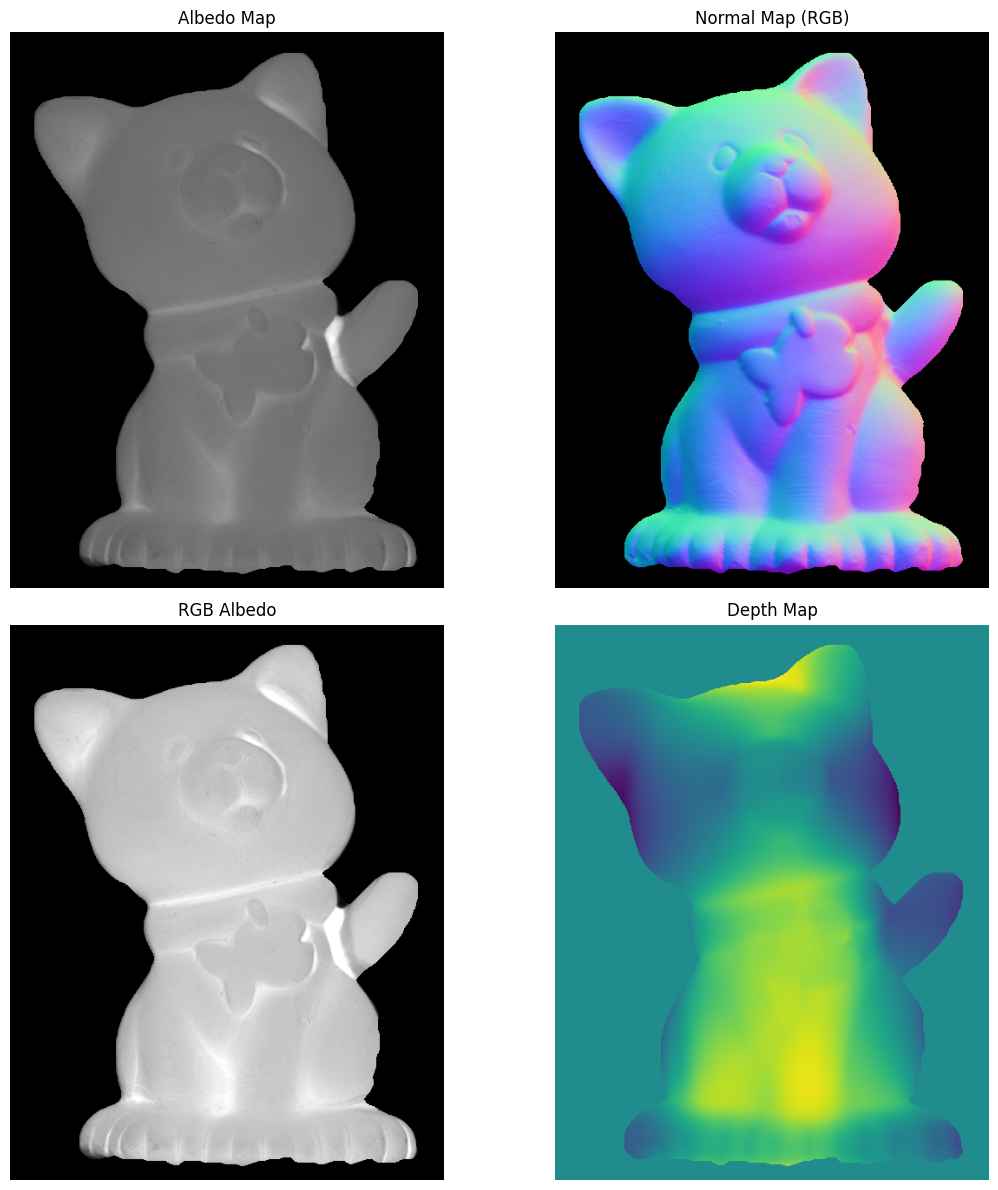

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Albedo
albedo_norm = albedo_map / albedo_map.max() if albedo_map.max() > 0 else albedo_map
axes[0, 0].imshow(albedo_norm, cmap='gray')
axes[0, 0].set_title('Albedo Map')
axes[0, 0].axis('off')

# Normal map
normal_vis = (normal_map + 1.0) / 2.0 * mask[:, :, np.newaxis]
axes[0, 1].imshow(normal_vis)
axes[0, 1].set_title('Normal Map (RGB)')
axes[0, 1].axis('off')

# RGB Albedo
color_norm = color_map / color_map.max() if color_map.max() > 0 else color_map
axes[1, 0].imshow(color_norm)
axes[1, 0].set_title('RGB Albedo')
axes[1, 0].axis('off')

# Depth map
axes[1, 1].imshow(depth_map, cmap='viridis')
axes[1, 1].set_title('Depth Map')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### 3D Point Cloud Reconstruction

Convert the depth map $z(x,y)$ to a 3D point cloud:

$$\mathbf{P} = \{(x, y, z(x,y)) \\mid M(x,y) = 1\}$$

Each point is colored by its grayscale albedo $\rho(x,y)$ to visualize surface reflectance properties.

The point cloud can be rendered interactively, allowing rotation and inspection of the reconstructed 3D geometry.

## 3D Visualization

## Interactive 3D Visualization with Albedo

In [34]:
def depth_to_point_cloud_with_albedo(depth_map, albedo_map, mask, subsample=1):
    """Convert depth map to point cloud with albedo colors"""
    H, W = depth_map.shape
    points_3d = []
    pixel_coords = []
    albedo_values = []
    
    for i in range(0, H, subsample):
        for j in range(0, W, subsample):
            if mask[i, j] > 0:
                points_3d.append([j, i, depth_map[i, j]])
                pixel_coords.append([i, j])
                albedo_values.append(albedo_map[i, j])
    
    return np.array(points_3d), np.array(pixel_coords), np.array(albedo_values)

def plot_point_cloud_with_albedo(points_3d, albedo_values, colorscale='Greys', 
                                   point_size=3, title='3D Reconstruction - Grayscale Albedo',
                                   camera_eye=dict(x=1.5, y=1.5, z=1.5)):
    """Create interactive 3D point cloud colored by albedo"""
    fig = go.Figure(data=[go.Scatter3d(
        x=points_3d[:, 0],
        y=points_3d[:, 1],
        z=points_3d[:, 2],
        mode='markers',
        marker=dict(
            size=point_size,
            color=albedo_values,
            colorscale=colorscale,
            colorbar=dict(title="Albedo"),
            showscale=True
        )
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Depth',
            camera=dict(eye=camera_eye),
            aspectmode='data'
        ),
        width=900,
        height=900
    )
    
    return fig

# Generate point cloud with albedo
points_3d, pixel_coords, albedo_values = depth_to_point_cloud_with_albedo(
    depth_map, albedo_map, mask, subsample=2
)

# Color by grayscale albedo
fig_gray = plot_point_cloud_with_albedo(
    points_3d=points_3d,
    albedo_values=albedo_values,
    colorscale='Greys',
    point_size=3,
    title='3D Reconstruction - Grayscale Albedo',
    camera_eye=dict(x=1.5, y=1.5, z=1.5)
)

fig_gray.show()
print(f'Created interactive 3D visualization with {len(points_3d)} points')

Created interactive 3D visualization with 43006 points


In [ ]:
# Optional: Color by depth for comparison
fig_depth = plot_point_cloud_with_albedo(
    points_3d=points_3d,
    albedo_values=points_3d[:, 2],  # Use depth (Z) for coloring
    colorscale='Viridis',
    point_size=3,
    title='3D Reconstruction - Colored by Depth',
    camera_eye=dict(x=1.5, y=1.5, z=1.5)
)

fig_depth.show()